<a href="https://colab.research.google.com/github/meghanclownfish/surf-gradient-prediction/blob/main/m_wave_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *data exploration*

*kaggle* https://www.kaggle.com/akdagmelih/ocean-wave-prediction-with-lstm

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import seaborn as sns
import os

*import csv*

In [28]:
from google.colab import files
uploaded = files.upload()

Saving wave_data_clean.csv to wave_data_clean (1).csv


*store csv as dataframe*

In [29]:
wave_data = pd.read_csv(io.BytesIO(uploaded["wave_data_clean.csv"]))
wave_data.head()

,Unnamed: 0,WVHT,DPD,APD,MWD,WTMP
0,0,1.19,8.33,5.80,120.0,11.8
1,1,1.15,7.69,5.89,132.0,11.8
2,2,1.12,7.14,5.78,147.0,11.7
3,3,1.05,7.14,5.61,143.0,11.7
4,4,0.99,6.67,5.58,151.0,11.7


*various data visualizations*

# *model one*

##*dropping and preparing data*

In [30]:
wave_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107989 entries, 0 to 107988
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  107989 non-null  int64  
 1   WVHT        107989 non-null  float64
 2   DPD         107989 non-null  float64
 3   APD         107989 non-null  float64
 4   MWD         107989 non-null  float64
 5   WTMP        107989 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.9 MB


In [47]:
wave_data_m1 = wave_data[["WVHT","MWD", "DPD", "WTMP" ]]
wave_data_m1.head()  

,WVHT,MWD,DPD,WTMP
0,1.19,120.0,8.33,11.8
1,1.15,132.0,7.69,11.8
2,1.12,147.0,7.14,11.7
3,1.05,143.0,7.14,11.7
4,0.99,151.0,6.67,11.7


## *split and prepare*

*model 1 (m1) inputs as: sea surface remperature, wave height, wave period, wave direction, wind speed*

In [48]:
from sklearn.preprocessing import MinMaxScaler

# Scaling all the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
wave_data_scaled = scaler.fit_transform(wave_data_m1)
print('Shape of the scaled data matrix: ', wave_data_m1.shape)

Shape of the scaled data matrix:  (107989, 4)


In [49]:
# Separete data into 2 groups for train and test
train = wave_data_scaled[:80000,]
test = wave_data_scaled[80000: ,]

# Shapes of our datasets
print('Shape of train data: ', train.shape)
print('Shape of test data: ', test.shape)

Shape of train data:  (80000, 4)
Shape of test data:  (27989, 4)


80% test 20% train


*prepare data, 30 input and 31 output*

In [50]:
def prepare_data(wave_data_scaled):
    databatch = 30
    x_list = []
    y_list = []
    
    for i in range(len(wave_data_scaled)-databatch-1):
        x_list.append(wave_data_scaled[i:i+databatch])
        y_list.append(wave_data_scaled[i+databatch+1])
        
    X_data = np.array(x_list)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[2], X_data.shape[1]))
    y_data = np.array(y_list)
    
    return X_data, y_data

In [51]:
prepare_data(wave_data_scaled)

(array([[[0.60169492, 0.38888889, 0.55798969, ..., 0.0989011 ,
          0.41525424, 0.53703704],
         [0.47551546, 0.09340659, 0.39830508, ..., 0.47222222,
          0.40463918, 0.09340659],
         [0.41525424, 0.47222222, 0.40463918, ..., 0.08791209,
          0.37288136, 0.5462963 ],
         [0.40463918, 0.08791209, 0.48305085, ..., 0.43518519,
          0.47551546, 0.08791209]],
 
        [[0.56779661, 0.5       , 0.47551546, ..., 0.09340659,
          0.39830508, 0.5       ],
         [0.47551546, 0.09340659, 0.38983051, ..., 0.47222222,
          0.40463918, 0.08791209],
         [0.41525424, 0.47222222, 0.40463918, ..., 0.08791209,
          0.48305085, 0.63888889],
         [0.34407216, 0.08791209, 0.43220339, ..., 0.60185185,
          0.47551546, 0.08791209]],
 
        [[0.54237288, 0.63888889, 0.40463918, ..., 0.09340659,
          0.38983051, 0.5       ],
         [0.47551546, 0.09340659, 0.38983051, ..., 0.47222222,
          0.40463918, 0.08791209],
         [0.37

In [52]:
# Executing the separation
X_train, y_train = prepare_data(train)
X_test, y_test = prepare_data(test)
print('X_train Shape : ', X_train.shape, 'y_train shape :', y_train.shape)
print('X_test Shape  : ', X_test.shape, ' y_test shape  :', y_test.shape)

X_train Shape :  (79969, 4, 30) y_train shape : (79969, 4)
X_test Shape  :  (27958, 4, 30)  y_test shape  : (27958, 4)


## *build the model*

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
seed(15)
import tensorflow as tf
tf.random.set_seed(15)

*model one*

dense(5)

In [56]:
def lstm_model_one(x_data, y_data, num_epochs, batch_size, learning_rate):

    # Creating the model
    model = Sequential()

    # Adding the first layer
    model.add(LSTM(32, input_shape=(x_data.shape[1], x_data.shape[2]), return_sequences=True))

    # Adding the second layer 
    model.add(LSTM(16, return_sequences=True))

    # Adding a dropout value in order to prevent overfiting
    model.add(Dropout(0.2))

    # Adding the third layer
    model.add(LSTM(10))
    
    # Adding the output layer. 6 nodes are selected because the data has 6 features
    model.add(Dense(4))
    
    # Choosing the optimizer
    optimizer = Adam(lr = learning_rate)
    
    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    # Fitting the model
    history = model.fit(x_data, y_data, validation_split=0.25, epochs=num_epochs, batch_size=batch_size)
    
    return model, history

In [57]:
history = lstm_model_one(X_train, y_train, num_epochs=15, batch_size=200, learning_rate=.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
300/300 [==============================] - 12s 18ms/step - loss: 0.0943 - accuracy: 0.4445 - val_loss: 0.0329 - val_accuracy: 0.6640
Epoch 2/15
300/300 [==============================] - 4s 14ms/step - loss: 0.0325 - accuracy: 0.6837 - val_loss: 0.0226 - val_accuracy: 0.7304
Epoch 3/15
300/300 [==============================] - 4s 13ms/step - loss: 0.0220 - accuracy: 0.7611 - val_loss: 0.0134 - val_accuracy: 0.8094
Epoch 4/15
300/300 [==============================] - 4s 13ms/step - loss: 0.0154 - accuracy: 0.8086 - val_loss: 0.0117 - val_accuracy: 0.8297
Epoch 5/15
300/300 [==============================] - 4s 13ms/step - loss: 0.0136 - accuracy: 0.8273 - val_loss: 0.0110 - val_accuracy: 0.8380
Epoch 6/15
300/300 [==============================] - 3s 11ms/step - loss: 0.0128 - accuracy: 0.8293 - val_loss: 0.0108 - val_accuracy: 0.8407
Epoch 7/15
300/300 [==============================] - 4s 12ms/step - loss: 0.0127 - accuracy: 0.8345 - val_loss: 0.0106 - val_accuracy: 0.841

## *visualize learning*

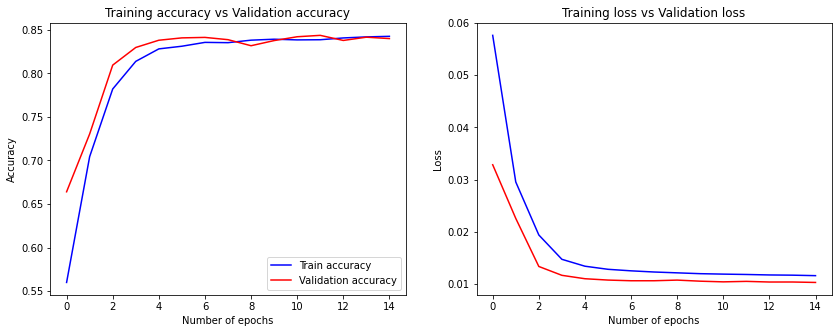

In [58]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history[1].history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history[1].history['val_accuracy'], color='red', label='Validation accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history[1].history['loss'], color='blue', label='Train loss')
plt.plot(history[1].history['val_loss'], color='red', label='Validation loss')
plt.title('Training loss vs Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel("Loss")
plt.show();

#*predictions*

In [59]:
# Defining function to predict datas
def predicting(data, y_real):
    predicted_data = history[0].predict(data)
    # Invert scaling process to get the normal values range for the features 
    predicted_data = scaler.inverse_transform(predicted_data)
    y_real = scaler.inverse_transform(y_real)
    
    return predicted_data, y_real

In [60]:
# Executing predictions
train_prediction, y_train = predicting(X_train, y_train)
test_prediction, y_test = predicting(X_test, y_test)

#*evaluating sucess*

In [61]:
# Defining function to investigate the root of mean squared errors (RMSE) between predicted and real data

import math
from sklearn.metrics import mean_squared_error

def examine_rmse(y_data, predicted_data):
    Score_wave_height = math.sqrt(mean_squared_error(y_data[:,0], predicted_data[:,0]))
    Score_dominant_wave_period = math.sqrt(mean_squared_error(y_data[:,1], predicted_data[:,1]))
    Score_average_wave_period = math.sqrt(mean_squared_error(y_data[:,2], predicted_data[:,2]))
    Score_dominant_period_direction = math.sqrt(mean_squared_error(y_data[:,3], predicted_data[:,3]))
    Score_water_temperature = math.sqrt(mean_squared_error(y_data[:,4], predicted_data[:,4]))
    
    
    print('RMSE_wvht      : ', Score_water_temperature)
    print('RMSE_dpd       : ', Score_dominant_wave_period)
    print('RMSE_apd       : ', Score_average_wave_period)
    print('RMSE_mwd       : ', Score_dominant_period_direction)
    print("RMSE_wtmp      : ", Score_water_temperature)



In [45]:
examine_rmse(y_train, train_prediction)

RMSE_wvht      :  0.4848170171689971
RMSE_dpd       :  12.58902739237146
RMSE_apd       :  1.1212774328961856
RMSE_mwd       :  0.29163237035702694
RMSE_wtmp      :  0.4848170171689971


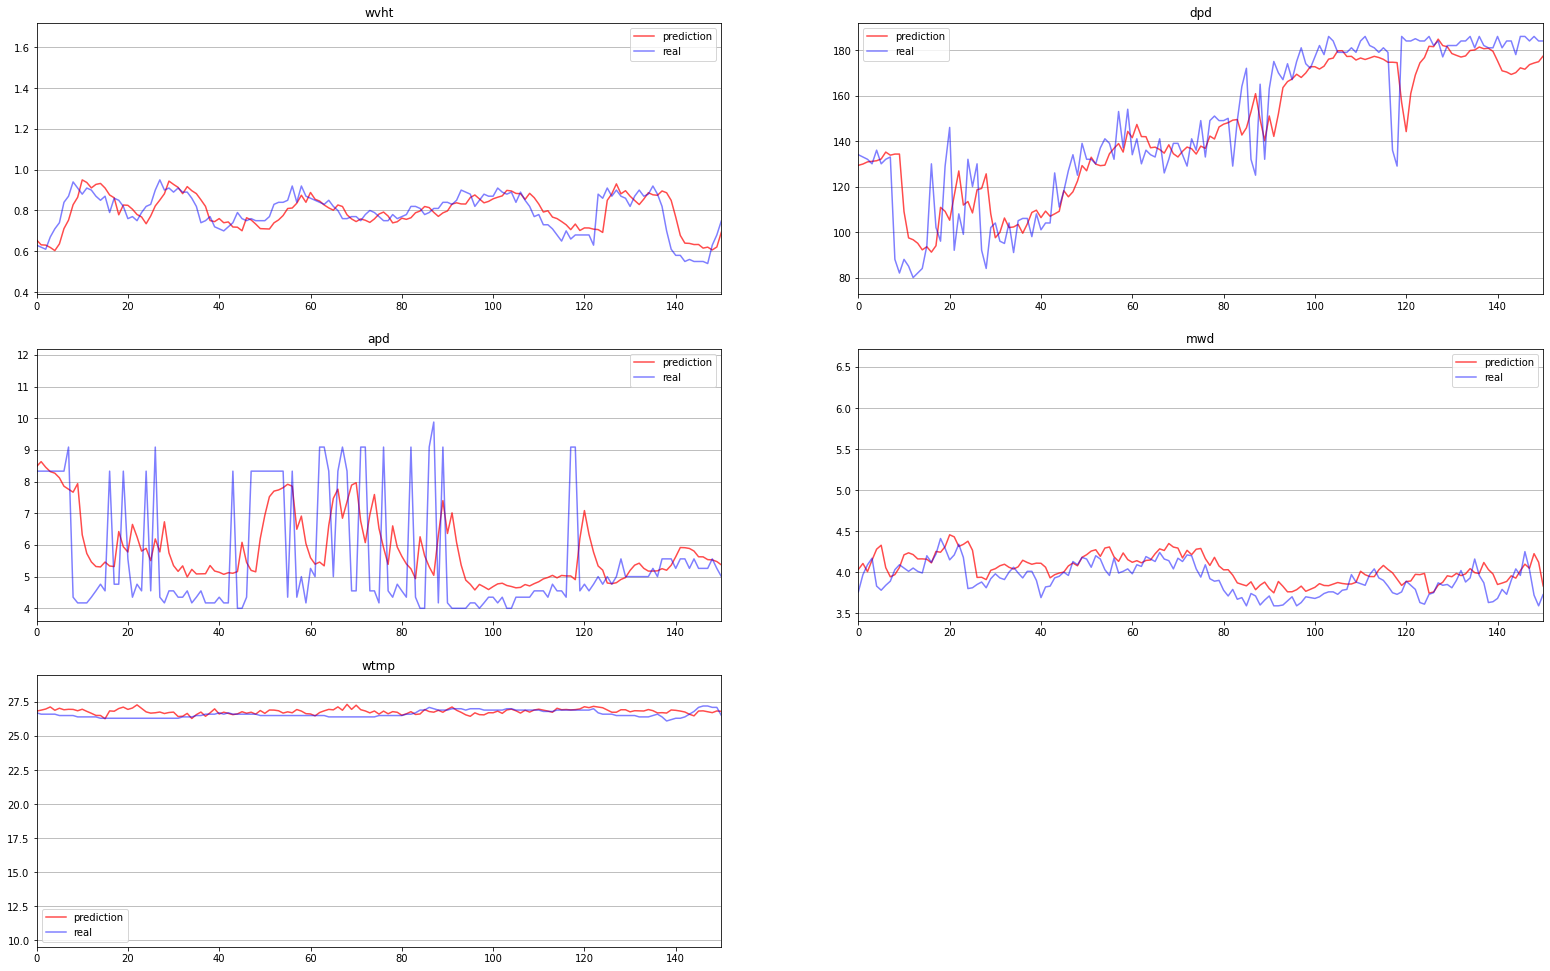

In [46]:
plt.figure(figsize=(27,35))


plt.subplot(6,2,1)
plt.xlim(0,150)
plt.plot(test_prediction[1300:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,0], color='blue', alpha=0.5, label='real')
plt.title('wvht')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,2)
plt.xlim(0,150)
plt.plot(test_prediction[1300:,1], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,1], color='blue', alpha=0.5, label='real')
plt.title('dpd')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,3)
plt.xlim(0,150)
plt.plot(test_prediction[1300:,2], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,2], color='blue', alpha=0.5, label='real')
plt.title('apd')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,4)
plt.xlim(0,150)
plt.plot(test_prediction[1300:,3], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,3], color='blue', alpha=0.5, label='real')
plt.title('mwd')
plt.legend()
plt.grid(b=True, axis='y')

plt.subplot(6,2,5)
plt.xlim(0,150)
plt.plot(test_prediction[1300:,4], color='red', alpha=0.7, label='prediction')
plt.plot(y_test[1300:,4], color='blue', alpha=0.5, label='real')
plt.title('wtmp')
plt.legend()
plt.grid(b=True, axis='y');

In [ ]:
print('Trainin Data Errors')
print(examine_rmse(y_train, train_prediction),'\n')
print('Test Data Errors')
print(examine_rmse(y_test, test_prediction))

Trainin Data Errors
RMSE_wvht      :  0.41383359951373483
RMSE_dpd       :  12.557845878644272
RMSE_apd       :  1.1239951469974037
RMSE_mwd       :  0.29171120058446026
RMSE_wtmp      :  0.41383359951373483
None 

Test Data Errors
RMSE_wvht      :  0.39425678256587454
RMSE_dpd       :  11.828752443108076
RMSE_apd       :  1.0897236492378168
RMSE_mwd       :  0.30738308936046155
RMSE_wtmp      :  0.39425678256587454
None


# *lime*

In [ ]:
!pip install lime

import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function

     |████████████████████████████████| 276kB 25.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=1720bc78c62430fd53b0ab4082a656b5e5b40b3e5454dd02786f14ac9a77fcc1
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
